In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.datasets import load_digits
from scipy.stats import sem
from AdjustedRandomForest import train
from mislabelling import symmetric_noise, pair_noise

data = load_digits()

In [2]:
def plot_with_error_band(x, y_mean, y_se, label, color, linestyle="-", alpha=0.2):
    """
    Plots a line with a shaded error band using mean and standard error.

    Parameters:
    - x: 1D array-like, x-axis values
    - y_mean: 1D array-like, mean values
    - y_se: 1D array-like, standard error values
    - label: str, label for the plot
    - color: str, color of the line and fill
    - linestyle: str, line style ('-', ':', etc.)
    - alpha: float, transparency of the shaded area
    """
    import matplotlib.pyplot as plt

    plt.plot(x, y_mean, label=label, color=color, linestyle=linestyle)
    plt.fill_between(
        x,
        y_mean - y_se,
        y_mean + y_se,
        alpha=alpha,
        color=color
    )

In [3]:
def run_relabelling_experiment(
    dataset,
    forest_class,
    noise_func,
    n_estimators=10,
    trials=35,
    resolution=20,
    test_size=0.25,
    iterations=10,
    methods=("standard", "bootstrapped", "control"),
    relabelling = True
):
    """
    Runs relabelling experiments over multiple trials and noise levels.

    Parameters:
    - dataset: sklearn-style object with `.data` and `.target`
    - forest_class: classifier class (e.g., RandomForestClassifier)
    - noise_func: callable, applies label noise, takes (y, noise_rate)
    - n_estimators: number of estimators for standard methods
    - trials: number of trials per noise level
    - resolution: number of noise steps (from 0 to 1)
    - test_size: test set proportion
    - iterations: number of adjusted RF iterations
    - methods: tuple of method names (default assumes 3: standard, bootstrapped, control)
    - relabelling: toggles relabelling capability in the adjusted random forest

    Returns:
    - accuracies_all: np.array (n_methods, resolution, trials)
    - relabelling_all: np.array (2, resolution, trials)  [only first 2 methods apply relabelling]
    - noise_levels: np.array of noise rates
    """

    n_methods = len(methods)
    accuracies_all = np.zeros((n_methods, resolution, trials))
    relabelling_all = np.zeros((2, resolution, trials))

    noise_levels = np.linspace(0, 1, resolution)

    for i, noise_rate in enumerate(noise_levels):
        for trial in range(trials):
            X_train, X_test, y_train, y_test = train_test_split(
                dataset.data, dataset.target, test_size=test_size
            )
            y_mislabelled = noise_func(np.copy(y_train), noise_rate)

            # Method 0: standard relabelling
            if ("standard") in methods:
                rf, corrected_y = train(forest_class, X_train, y_mislabelled, np.unique(dataset.target), n_estimators=n_estimators, iterations=iterations, relabelling=relabelling)
                y_pred = rf.predict(X_test)
                relabelling_all[0, i, trial] = np.sum(corrected_y != y_train)
                accuracies_all[0, i, trial] = metrics.accuracy_score(y_test, y_pred)

            # Method 1: bootstrapped relabelling
            if ("bootstrapped") in methods:
                rf, corrected_y = train(forest_class, X_train, y_mislabelled, np.unique(dataset.target), n_estimators=n_estimators, bootstrapping=True, iterations=iterations, relabelling=relabelling)
                y_pred = rf.predict(X_test)
                relabelling_all[1, i, trial] = np.sum(corrected_y != y_train)
                accuracies_all[1, i, trial] = metrics.accuracy_score(y_test, y_pred)

            # Method 2: control (no relabelling, more estimators)
            if ("control") in methods:
                rf = forest_class(n_estimators=n_estimators * iterations, criterion="entropy")
                rf.fit(X_train, y_mislabelled)
                y_pred = rf.predict(X_test)
                accuracies_all[2, i, trial] = metrics.accuracy_score(y_test, y_pred)

    return accuracies_all, relabelling_all, noise_levels


In [4]:
def process_experiment_results(
    accuracies_all,
    relabelling_all=None,
    resolution=20,
    test_size=0.25,
    dataset_size=None  # total number of samples before train/test split
):
    """
    Processes raw experiment outputs to compute mean & SE for accuracies and relabelling success.

    Parameters:
    - accuracies_all: array-like (n_methods, resolution, trials)
    - relabelling_all: array-like (n_methods_relabelling, resolution, trials), optional
    - resolution: number of noise levels
    - test_size: test split ratio used during training
    - dataset_size: total number of original samples (before train/test split)

    Returns:
    - accuracies_mean: (n_methods, resolution)
    - accuracies_se: (n_methods, resolution)
    - relabelling_success: (n_methods_relabelling, resolution) or None
    - relabelling_se: (n_methods_relabelling, resolution) or None
    - noise_levels: (resolution,)
    """
    
    accuracies_all = np.array(accuracies_all)
    accuracies_mean = accuracies_all.mean(axis=2)
    accuracies_se = sem(accuracies_all, axis=2)

    relabelling_success = None
    relabelling_se = None

    if relabelling_all is not None:
        relabelling_all = np.array(relabelling_all)
        n_relabel_methods = relabelling_all.shape[0]
        relabelling_success = np.ones((n_relabel_methods, resolution))
        relabelling_se = np.zeros((n_relabel_methods, resolution))

        if dataset_size is None:
            raise ValueError("dataset_size must be provided when relabelling_all is used")

        n_samples = dataset_size * (1 - test_size)
        noise_levels = np.linspace(0, 1, resolution)

        for i in range(1, resolution):  # skip 0 to avoid division by zero
            for j in range(n_relabel_methods):
                denom = n_samples * noise_levels[i]
                if denom == 0:
                    continue
                rates = relabelling_all[j][i] / denom
                relabelling_success[j][i] = 1 - np.mean(rates)
                relabelling_se[j][i] = sem(1 - rates)
    else:
        noise_levels = np.linspace(0, 1, resolution)

    return accuracies_mean, accuracies_se, relabelling_success, relabelling_se, noise_levels

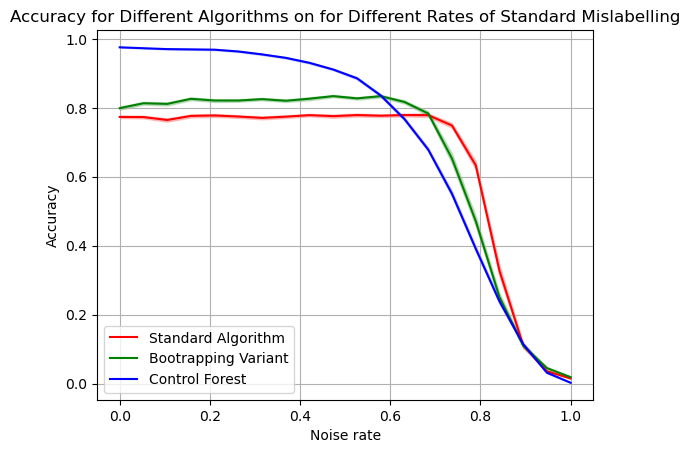

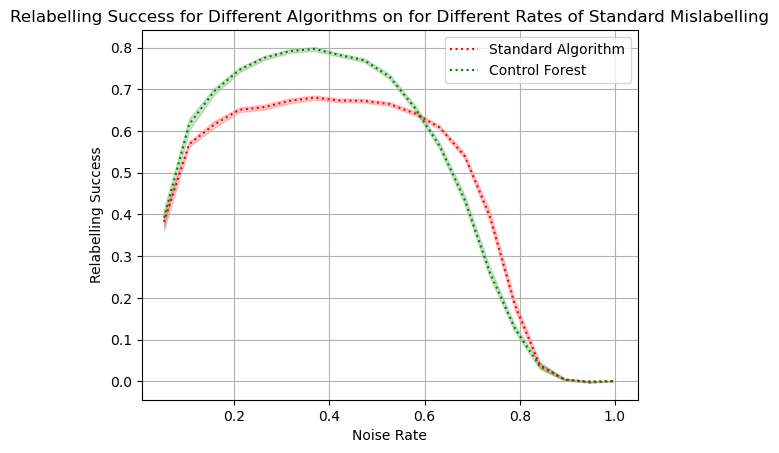

In [5]:
RESOLUTION = 20
TRIALS = 35
N_ESTIMATORS = 10
TEST_SIZE = 0.25
ITERATIONS = 10

accuracies_all, relabelling_all, noise_levels = run_relabelling_experiment(data, RandomForestClassifier, symmetric_noise, n_estimators=N_ESTIMATORS, trials=TRIALS, resolution=RESOLUTION, test_size=TEST_SIZE, iterations=ITERATIONS)
accuracies_mean, accuracies_se, relabelling_success, relabelling_se, x_axis = process_experiment_results(accuracies_all, relabelling_all, RESOLUTION, TEST_SIZE, len(data.target))

# Accuracy lines
plot_with_error_band(x_axis, accuracies_mean[0], accuracies_se[0], label="Standard Algorithm", color="red")
plot_with_error_band(x_axis, accuracies_mean[1], accuracies_se[1], label="Bootrapping Variant", color="green")
plot_with_error_band(x_axis, accuracies_mean[2], accuracies_se[2], label="Control Forest", color="blue")

plt.xlabel("Noise rate")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different Algorithms on for Different Rates of Standard Mislabelling")
plt.legend()
plt.grid(True)
plt.show()

# Relabelling success (skip index 0 to avoid div by zero)
plot_with_error_band(x_axis[1:], relabelling_success[0][1:], relabelling_se[0][1:], label="Standard Algorithm", color="red", linestyle=":")
plot_with_error_band(x_axis[1:], relabelling_success[1][1:], relabelling_se[1][1:], label="Control Forest", color="green", linestyle=":")

plt.xlabel("Noise Rate")
plt.ylabel("Relabelling Success")
plt.title("Relabelling Success for Different Algorithms on for Different Rates of Standard Mislabelling")
plt.legend()
plt.grid(True)
plt.show()

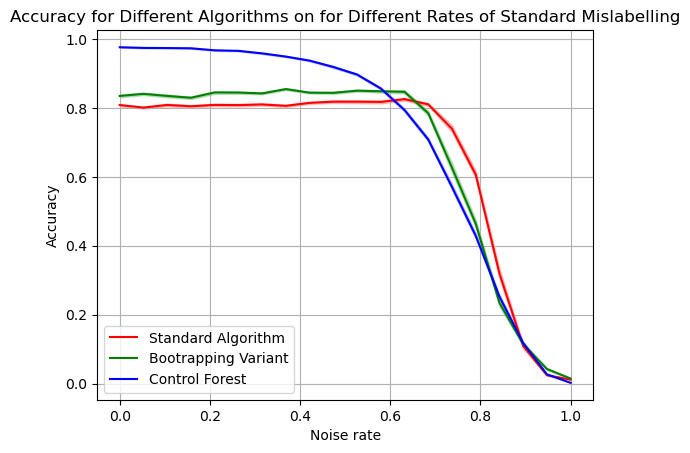

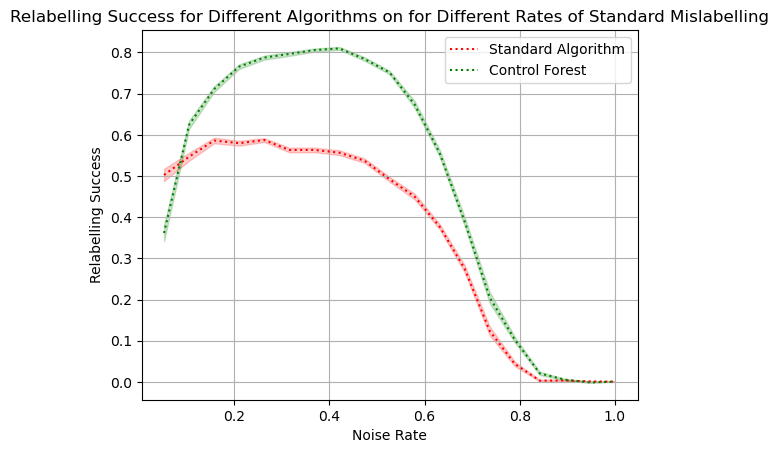

In [6]:
# MORE ESTIMATORS
RESOLUTION = 20
TRIALS = 35
N_ESTIMATORS = 20
TEST_SIZE = 0.25
ITERATIONS = 10

accuracies_all, relabelling_all, noise_levels = run_relabelling_experiment(data, RandomForestClassifier, symmetric_noise, N_ESTIMATORS, TRIALS, RESOLUTION, TEST_SIZE, ITERATIONS)
accuracies_mean, accuracies_se, relabelling_success, relabelling_se, x_axis = process_experiment_results(accuracies_all, relabelling_all, RESOLUTION, TEST_SIZE, len(data.target))

# Accuracy lines
plot_with_error_band(x_axis, accuracies_mean[0], accuracies_se[0], label="Standard Algorithm", color="red")
plot_with_error_band(x_axis, accuracies_mean[1], accuracies_se[1], label="Bootrapping Variant", color="green")
plot_with_error_band(x_axis, accuracies_mean[2], accuracies_se[2], label="Control Forest", color="blue")

plt.xlabel("Noise rate")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different Algorithms on for Different Rates of Standard Mislabelling")
plt.legend()
plt.grid(True)
plt.show()

# Relabelling success (skip index 0 to avoid div by zero)
plot_with_error_band(x_axis[1:], relabelling_success[0][1:], relabelling_se[0][1:], label="Standard Algorithm", color="red", linestyle=":")
plot_with_error_band(x_axis[1:], relabelling_success[1][1:], relabelling_se[1][1:], label="Control Forest", color="green", linestyle=":")

plt.xlabel("Noise Rate")
plt.ylabel("Relabelling Success")
plt.title("Relabelling Success for Different Algorithms on for Different Rates of Standard Mislabelling")
plt.legend()
plt.grid(True)
plt.show()

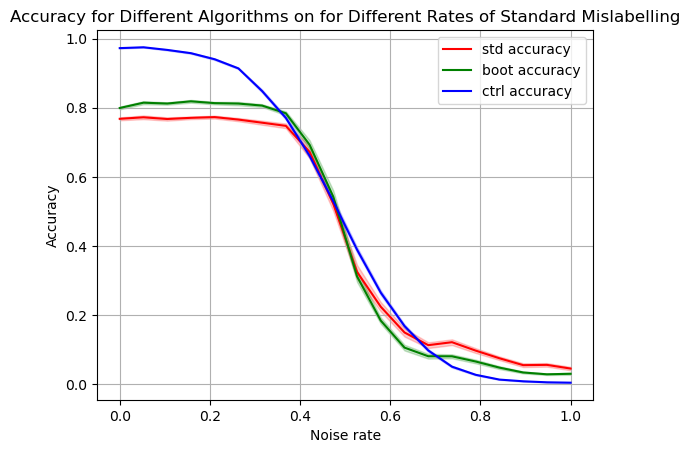

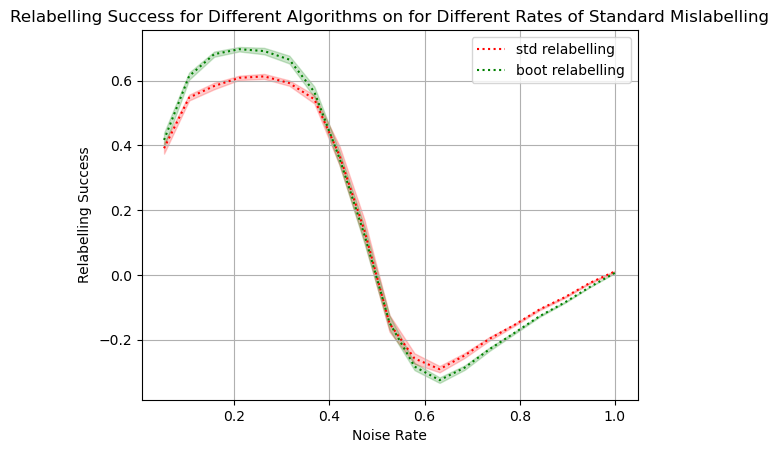

In [7]:
# PAIR NOISE
RESOLUTION = 20
TRIALS = 35
N_ESTIMATORS = 10
TEST_SIZE = 0.25


accuracies_all, relabelling_all, noise_levels = run_relabelling_experiment(data, RandomForestClassifier, pair_noise)
accuracies_mean, accuracies_se, relabelling_success, relabelling_se, x_axis = process_experiment_results(accuracies_all, relabelling_all, RESOLUTION, TEST_SIZE, len(data.target))

# Accuracy lines
plot_with_error_band(x_axis, accuracies_mean[0], accuracies_se[0], label="std accuracy", color="red")
plot_with_error_band(x_axis, accuracies_mean[1], accuracies_se[1], label="boot accuracy", color="green")
plot_with_error_band(x_axis, accuracies_mean[2], accuracies_se[2], label="ctrl accuracy", color="blue")

plt.xlabel("Noise rate")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different Algorithms on for Different Rates of Standard Mislabelling")
plt.legend()
plt.grid(True)
plt.show()

# Relabelling success (skip index 0 to avoid div by zero)
plot_with_error_band(x_axis[1:], relabelling_success[0][1:], relabelling_se[0][1:], label="std relabelling", color="red", linestyle=":")
plot_with_error_band(x_axis[1:], relabelling_success[1][1:], relabelling_se[1][1:], label="boot relabelling", color="green", linestyle=":")

plt.xlabel("Noise Rate")
plt.ylabel("Relabelling Success")
plt.title("Relabelling Success for Different Algorithms on for Different Rates of Standard Mislabelling")
plt.legend()
plt.grid(True)
plt.show()

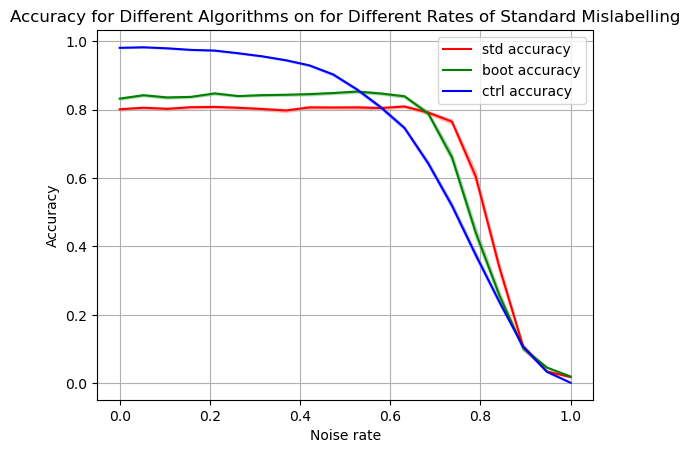

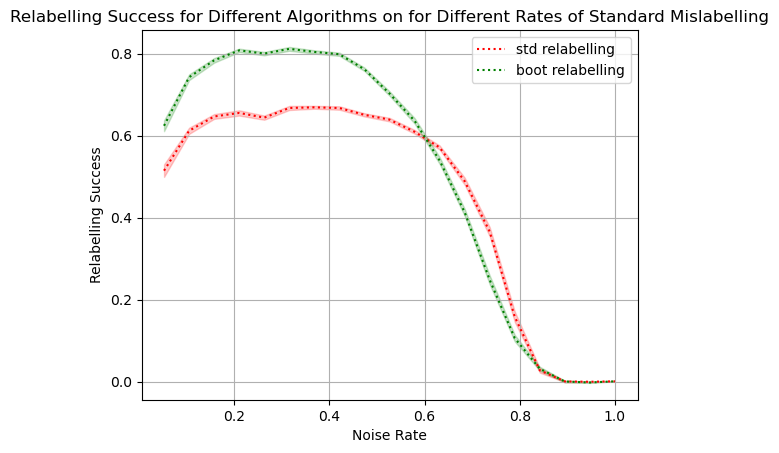

In [8]:
# EXTRATREES
RESOLUTION = 20
TRIALS = 35
N_ESTIMATORS = 10
TEST_SIZE = 0.25


accuracies_all, relabelling_all, noise_levels = run_relabelling_experiment(data, ExtraTreesClassifier, symmetric_noise)
accuracies_mean, accuracies_se, relabelling_success, relabelling_se, x_axis = process_experiment_results(accuracies_all, relabelling_all, RESOLUTION, TEST_SIZE, len(data.target))

# Accuracy lines
plot_with_error_band(x_axis, accuracies_mean[0], accuracies_se[0], label="std accuracy", color="red")
plot_with_error_band(x_axis, accuracies_mean[1], accuracies_se[1], label="boot accuracy", color="green")
plot_with_error_band(x_axis, accuracies_mean[2], accuracies_se[2], label="ctrl accuracy", color="blue")

plt.xlabel("Noise rate")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different Algorithms on for Different Rates of Standard Mislabelling")
plt.legend()
plt.grid(True)
plt.show()

# Relabelling success (skip index 0 to avoid div by zero)
plot_with_error_band(x_axis[1:], relabelling_success[0][1:], relabelling_se[0][1:], label="std relabelling", color="red", linestyle=":")
plot_with_error_band(x_axis[1:], relabelling_success[1][1:], relabelling_se[1][1:], label="boot relabelling", color="green", linestyle=":")

plt.xlabel("Noise Rate")
plt.ylabel("Relabelling Success")
plt.title("Relabelling Success for Different Algorithms on for Different Rates of Standard Mislabelling")
plt.legend()
plt.grid(True)
plt.show()

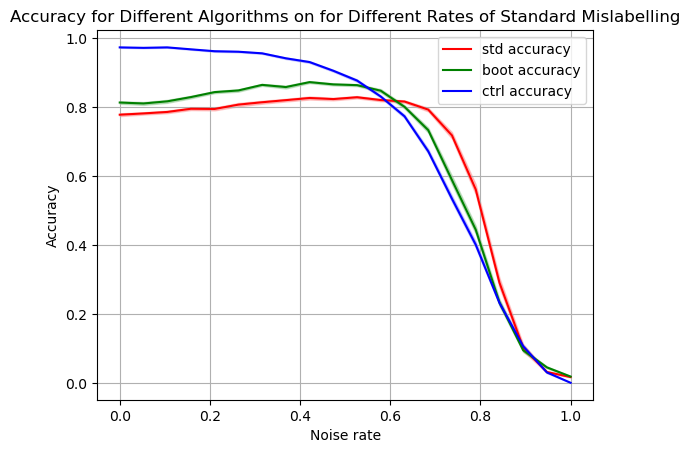

In [9]:
# NO RELABELLING
RESOLUTION = 20
TRIALS = 35
N_ESTIMATORS = 10
TEST_SIZE = 0.25


accuracies_all, relabelling_all, noise_levels = run_relabelling_experiment(data, RandomForestClassifier, symmetric_noise, relabelling=False)
accuracies_mean, accuracies_se, relabelling_success, relabelling_se, x_axis = process_experiment_results(accuracies_all, resolution=RESOLUTION, test_size=TEST_SIZE, dataset_size=len(data.target))

# Accuracy lines
plot_with_error_band(x_axis, accuracies_mean[0], accuracies_se[0], label="std accuracy", color="red")
plot_with_error_band(x_axis, accuracies_mean[1], accuracies_se[1], label="boot accuracy", color="green")
plot_with_error_band(x_axis, accuracies_mean[2], accuracies_se[2], label="ctrl accuracy", color="blue")

plt.xlabel("Noise rate")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different Algorithms on for Different Rates of Standard Mislabelling")
plt.legend()
plt.grid(True)
plt.show()

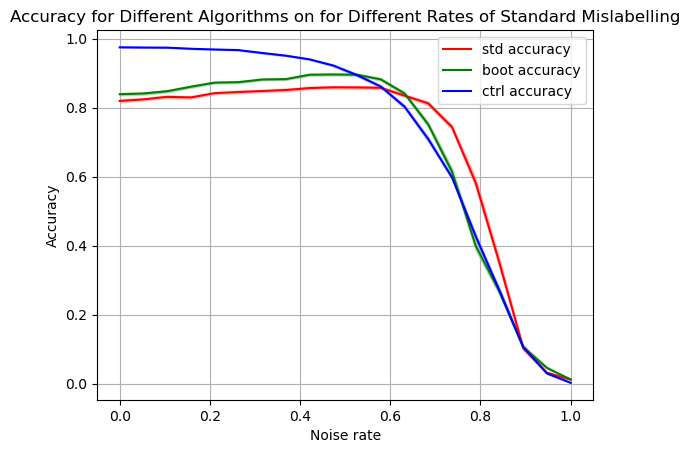

In [10]:
# NO RELABELLING
# LARGER FOREST
RESOLUTION = 20
TRIALS = 35
N_ESTIMATORS = 25
TEST_SIZE = 0.25


accuracies_all, relabelling_all, noise_levels = run_relabelling_experiment(data, RandomForestClassifier, symmetric_noise, relabelling=False, n_estimators=N_ESTIMATORS)
accuracies_mean, accuracies_se, relabelling_success, relabelling_se, x_axis = process_experiment_results(accuracies_all, resolution=RESOLUTION, test_size=TEST_SIZE, dataset_size=len(data.target))

# Accuracy lines
plot_with_error_band(x_axis, accuracies_mean[0], accuracies_se[0], label="std accuracy", color="red")
plot_with_error_band(x_axis, accuracies_mean[1], accuracies_se[1], label="boot accuracy", color="green")
plot_with_error_band(x_axis, accuracies_mean[2], accuracies_se[2], label="ctrl accuracy", color="blue")

plt.xlabel("Noise rate")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different Algorithms on for Different Rates of Standard Mislabelling")
plt.legend()
plt.grid(True)
plt.show()